## Extract latent representations in DLPFC data using spatially aware autoencoders

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

from smoother import SpatialWeightMatrix, SpatialLoss, ContrastiveSpatialLoss
from smoother.models.reduction import PCA, LinearAutoEncoder

### Load the brain cortex dataset (preprocessed)

In [2]:
# change the data directory accordingly
DATA_DIR = "./data/"

# layer annotation
anno_true = pd.read_csv(DATA_DIR + "DLPFC_151673_layer_annotation.txt", sep = " ", header=0)
anno_true.index = anno_true.index.str.split('.').str[0]

# read in log_count matrices
# spatial log-normalized count matrix, num_gene x num_spot
y_df = pd.read_csv(DATA_DIR + "DLPFC_151673_marker_log_exp.txt", sep = " ", header=0)
y_df = y_df.loc[:,anno_true.index]

# spatial coordinates, num_spot x 2
# here we are using 10x Visium's pixel-level coordinates
# i.e., 'pxl_col_in_fullres' and 'pxl_row_in_fullres'
coords = pd.read_csv(DATA_DIR + "DLPFC_151673_coords.txt", sep = " ", header=0)
coords = coords.loc[y_df.columns,:]

y = torch.tensor(y_df.values).float()

print(f"Number of genes: {y_df.shape[0]}")
print(f"Number of spots: {y_df.shape[1]}")
print("Layer spot counts:")
anno_true.layer.value_counts()

Number of genes: 350
Number of spots: 3611
Layer spot counts:


L3    989
L6    692
L5    673
WM    513
L1    273
L2    253
L4    218
Name: layer, dtype: int64

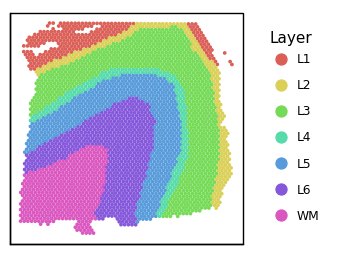

<ggplot: (319727511)>

In [3]:
df_slide = pd.concat([anno_true, coords], axis=1)
df_slide.columns = ['layer', 'sample', 'x', 'y']
ggplot(df_slide, aes(x = 'y', y = '-x', color = 'layer')) + \
    geom_point(size=0.5) + \
    labs(x = "", y = "", color = "Layer") + \
    theme_classic() + \
    theme(figure_size = (3,3),
             axis_text = element_blank(),
             axis_ticks = element_blank(),
             panel_border = element_line(color = 'black')) + \
    guides(color = guide_legend(override_aes = {'size':4}, ncol=1))

### Principal component analysis (PCA)

#### PCA - wo spatial loss

In [4]:
# initialize with SVD solution
m1 = PCA(num_feature = y.shape[0], num_pc = 10)
m1.reduce(y, tol = 1e-5, lr = 1e-1, max_epochs=-1, verbose=False, init_with_svd=True)

# random initialization
m2 = PCA(num_feature = y.shape[0], num_pc = 10)
m2.reduce(y, tol = 1e-5, lr = 1e-1, max_epochs=-1, verbose=False, init_with_svd=False)

=== Time  1.90s. Total epoch 928. Final Loss: (total) -9.6742. (recon) -9.6742. (spatial) 0.0000.
=== Time  3.52s. Total epoch 1058. Final Loss: (total) -9.6722. (recon) -9.6722. (spatial) 0.0000.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


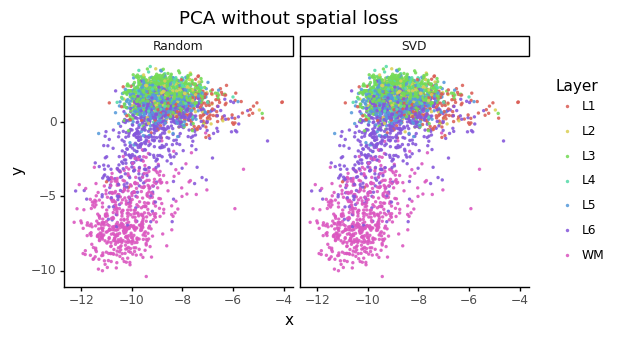

<ggplot: (321638866)>

In [5]:
df1 = pd.DataFrame(m1(y).detach()[0:3,:].T, columns=['x', 'y', 'z'])
df1['init'] = 'SVD'
df2 = pd.DataFrame(m2(y).detach()[0:3,:].T, columns=['x', 'y', 'z'])
df2['init'] = 'Random'

df_pca = pd.concat([df1, df2])

df_pca['layer'] = np.tile(anno_true['layer'].values, 2)

ggplot(df_pca, aes(x = 'x', y = 'y', color = 'layer')) + \
    facet_wrap('~init') + \
    geom_point(size = 0.4, alpha = 0.8) + \
    labs(title = 'PCA without spatial loss', color = 'Layer') +\
    theme_classic() + \
    theme(figure_size = (6,3))

#### PCA - w regular spatial loss

In [6]:
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords)
weights.scale_by_expr(y)

# prepare spatial loss
spatial_loss = SpatialLoss('icar', weights, 0.99, standardize_cov=True)
num_gene = y.shape[0]
num_pc = 10

l_sp_list = [0, 1, 3, 10, 30]
pca_w_rsp_list = [PCA(num_feature = num_gene, num_pc = num_pc) for _ in l_sp_list]

dr_configs = {'st_expr':y, 'spatial_loss':spatial_loss, 'tol':1e-5, 'lr':1e-1, 'max_epochs':-1, 'verbose':False}
for m, l_sp in zip(pca_w_rsp_list, l_sp_list):
    m.reduce(lambda_spatial_loss=l_sp, **dr_configs)

Number of spots: 3611. Average number of neighbors per spot:  5.86.
=== Time  1.58s. Total epoch 777. Final Loss: (total) -9.6693. (recon) -9.6693. (spatial) 0.0000.
=== Time  5.06s. Total epoch 1448. Final Loss: (total) -8.5504. (recon) -9.3084. (spatial) 0.7579.
=== Time  6.73s. Total epoch 1585. Final Loss: (total) -7.3735. (recon) -9.0199. (spatial) 1.6465.
=== Time  8.48s. Total epoch 1676. Final Loss: (total) -4.1460. (recon) -8.0292. (spatial) 3.8831.
=== Time  8.10s. Total epoch 1957. Final Loss: (total) 0.0339. (recon) -0.0010. (spatial) 0.0349.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


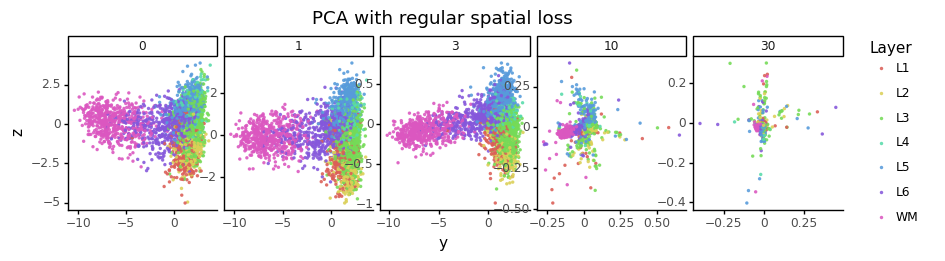

<ggplot: (319765402)>

In [7]:
h_list = [m(y).detach() for m in pca_w_rsp_list]

df_pca_h = []
for i, h in enumerate(h_list):
    _df = pd.DataFrame(h.T[:,0:3], columns=['x', 'y', 'z'])
    _df['l_sp_loss'] = l_sp_list[i]
    _df['layer'] = anno_true['layer'].values
    df_pca_h.append(_df)

df_pca_h = pd.concat(df_pca_h)

ggplot(df_pca_h, aes(x = 'y', y = 'z', color = 'layer')) + \
    facet_wrap('~ l_sp_loss', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'PCA with regular spatial loss', color = 'Layer') + \
    theme(figure_size = (10,2))

#### PCA - w contrastive spatial loss

In [8]:
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords)
weights.scale_by_expr(y)

# prepare spatial loss
spatial_loss = ContrastiveSpatialLoss(
    spatial_weights=weights, num_perm=20, neg2pos_ratio=0.1)

num_gene = y.shape[0]
num_pc = 10

l_sp_list = [0, 1, 3, 10, 30]
pca_w_csp_list = [PCA(num_feature = num_gene, num_pc = num_pc) for _ in l_sp_list]

dr_configs = {'st_expr':y, 'spatial_loss':spatial_loss, 'tol':1e-5, 'lr':1e-1, 'max_epochs':-1, 'verbose':False}
for m, l_sp in zip(pca_w_csp_list, l_sp_list):
    m.reduce(lambda_spatial_loss=l_sp, **dr_configs)

Number of spots: 3611. Average number of neighbors per spot:  5.86.
=== Time  3.44s. Total epoch 777. Final Loss: (total) -9.6693. (recon) -9.6693. (spatial) 0.0000.
=== Time  0.66s. Total epoch 17. Final Loss: (total) -9.1573. (recon) -9.6097. (spatial) 0.4524.
=== Time  6.00s. Total epoch 171. Final Loss: (total) -8.5303. (recon) -9.4578. (spatial) 0.9275.
=== Time  5.42s. Total epoch 156. Final Loss: (total) -7.4301. (recon) -9.1449. (spatial) 1.7148.
=== Time  2.82s. Total epoch 87. Final Loss: (total) -4.6235. (recon) -8.6724. (spatial) 4.0489.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


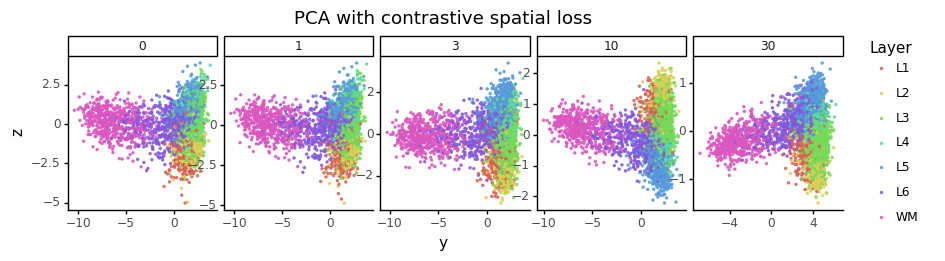

<ggplot: (321747524)>

In [9]:
h_list = [m(y).detach() for m in pca_w_csp_list]

df_pca_h = []
for i, h in enumerate(h_list):
    _df = pd.DataFrame(h.T[:,0:3], columns=['x', 'y', 'z'])
    _df['l_sp_loss'] = l_sp_list[i]
    _df['layer'] = anno_true['layer'].values
    df_pca_h.append(_df)

df_pca_h = pd.concat(df_pca_h)

ggplot(df_pca_h, aes(x = 'y', y = 'z', color = 'layer')) + \
    facet_wrap('~ l_sp_loss', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'PCA with contrastive spatial loss', color = 'Layer') + \
    theme(figure_size = (10,2))

### Linear autoencoder (LAE)

#### LAE - wo spatial loss

In [10]:
torch.manual_seed(20221005)

# linear autoencoder
n_gene = y.shape[0]
n_hidden = 10

lae1 = LinearAutoEncoder(n_gene, n_hidden)
lae1.reduce(y, spatial_loss=None,
           lambda_spatial_loss=0, lambda_orth_loss=3, 
           init_with_pca=True,
           lr = 3e-3, max_epochs=100, verbose=True, patience = 5)

lae2 = LinearAutoEncoder(n_gene, n_hidden)
lae2.reduce(y, spatial_loss=None,
           lambda_spatial_loss=0, lambda_orth_loss=3, 
           init_with_pca=False,
           lr = 3e-3, max_epochs=100, verbose=True, patience = 5)

Epoch 10. Loss: (total) 7.8782. (recon) 0.3114. (orth) 7.5668. (spatial) 0.0000.
=== Time  0.17s. Total epoch 13. Final Loss: (total) 8.1801. (recon) 0.3137. (orth) 7.8664. (spatial) 0.0000.
Epoch 10. Loss: (total) 22.7458. (recon) 0.7904. (orth) 21.9554. (spatial) 0.0000.
=== Time  0.19s. Total epoch 16. Final Loss: (total) 19.2805. (recon) 0.6926. (orth) 18.5879. (spatial) 0.0000.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


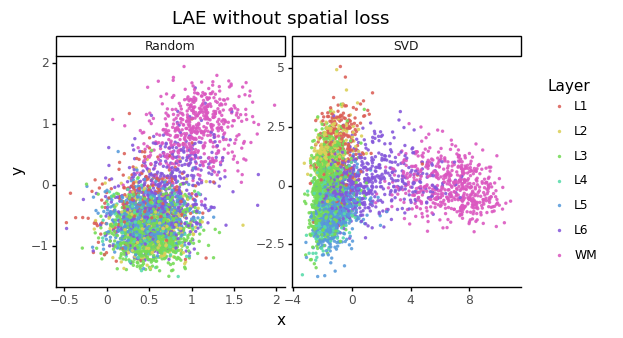

<ggplot: (325774186)>

In [11]:
df1 = pd.DataFrame(lae1.encode(y).detach()[:,0:3], columns=['x', 'y', 'z'])
df1['init'] = 'SVD'
df2 = pd.DataFrame(lae2.encode(y).detach()[:,0:3], columns=['x', 'y', 'z'])
df2['init'] = 'Random'

df_lae = pd.concat([df1, df2])
df_lae['layer'] = np.tile(anno_true['layer'].values, 2)

ggplot(df_lae, aes(x = 'x', y = 'y', color = 'layer')) + \
    facet_wrap('~init', scales = 'free') + \
    geom_point(size = 0.4, alpha = 0.8) + \
    labs(title = 'LAE without spatial loss', color = 'Layer') +\
    theme_classic() + \
    theme(figure_size = (6,3))

#### LAE - w regular spatial loss

In [12]:
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords)
weights.scale_by_expr(y)

# prepare spatial loss
spatial_loss = SpatialLoss('icar', weights, 0.99, standardize_cov=True)

num_gene = y.shape[0]
num_hidden = 10

l_sp_list = [0, 1, 3, 10, 30, 100]
lae_w_rsp_list = [LinearAutoEncoder(num_feature = num_gene, num_hidden = num_hidden) for _ in l_sp_list]

dr_configs = {'st_expr':y, 'spatial_loss':spatial_loss,
              'lambda_orth_loss':1, 'init_with_pca':True,
              'tol':1e-5, 'lr':3e-3, 'max_epochs':-1, 'verbose':False}
for m, l_sp in zip(lae_w_rsp_list, l_sp_list):
    m.reduce(lambda_spatial_loss=l_sp, **dr_configs)

Number of spots: 3611. Average number of neighbors per spot:  5.86.
=== Time  0.59s. Total epoch 50. Final Loss: (total) 0.9223. (recon) 0.3086. (orth) 0.6137. (spatial) 0.0000.
=== Time  1.37s. Total epoch 75. Final Loss: (total) 1.9947. (recon) 0.3091. (orth) 0.6130. (spatial) 1.0726.
=== Time  1.46s. Total epoch 91. Final Loss: (total) 3.2152. (recon) 0.3886. (orth) 0.5613. (spatial) 2.2653.
=== Time  0.91s. Total epoch 59. Final Loss: (total) 6.2935. (recon) 0.3630. (orth) 1.0501. (spatial) 4.8805.
=== Time  1.16s. Total epoch 55. Final Loss: (total) 7.9443. (recon) 0.3959. (orth) 3.2572. (spatial) 4.2912.
=== Time  0.71s. Total epoch 38. Final Loss: (total) 10.1480. (recon) 0.4759. (orth) 6.7370. (spatial) 2.9351.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


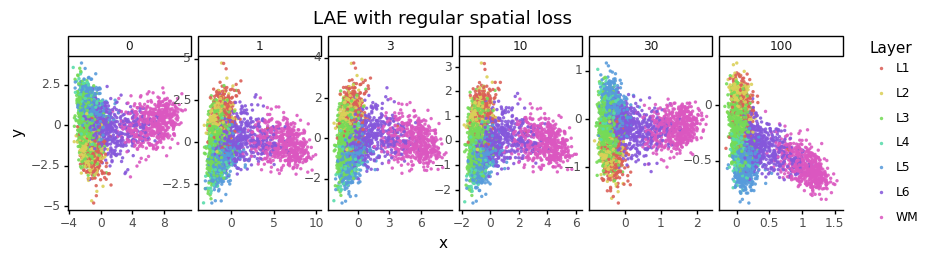

<ggplot: (319626123)>

In [13]:
h_list = [m.encode(y).detach() for m in lae_w_rsp_list]

df_lae_h = []
for i, h in enumerate(h_list):
    _df = pd.DataFrame(h[:,0:3], columns=['x', 'y', 'z'])
    _df['l_sp_loss'] = l_sp_list[i]
    _df['layer'] = anno_true['layer'].values
    df_lae_h.append(_df)

df_lae_h = pd.concat(df_lae_h)

ggplot(df_lae_h, aes(x = 'x', y = 'y', color = 'layer')) + \
    facet_wrap('~ l_sp_loss', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'LAE with regular spatial loss', color = 'Layer') + \
    theme(figure_size = (10,2))

#### LAE - w contrastive spatial loss

In [14]:
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords)
weights.scale_by_expr(y)

# prepare spatial loss
spatial_loss = ContrastiveSpatialLoss(
    spatial_weights=weights, num_perm=20, neg2pos_ratio=0.05)

num_gene = y.shape[0]
num_pc = 10

l_sp_list = [0, 1, 3, 10, 30, 100]
lae_w_csp_list = [LinearAutoEncoder(num_feature = num_gene, num_hidden = num_hidden) for _ in l_sp_list]

dr_configs = {'st_expr':y, 'spatial_loss':spatial_loss,
              'lambda_orth_loss':1, 'init_with_pca':True,
              'tol':1e-5, 'lr':3e-3, 'max_epochs':-1, 'verbose':False}
for m, l_sp in zip(lae_w_csp_list, l_sp_list):
    m.reduce(lambda_spatial_loss=l_sp, **dr_configs)

Number of spots: 3611. Average number of neighbors per spot:  5.86.
=== Time  0.59s. Total epoch 50. Final Loss: (total) 0.9223. (recon) 0.3086. (orth) 0.6137. (spatial) 0.0000.
=== Time  3.88s. Total epoch 84. Final Loss: (total) 1.3133. (recon) 0.3019. (orth) 0.5769. (spatial) 0.4345.
=== Time  5.10s. Total epoch 101. Final Loss: (total) 2.1426. (recon) 0.3061. (orth) 0.7223. (spatial) 1.1143.
=== Time  5.09s. Total epoch 115. Final Loss: (total) 3.0903. (recon) 0.3905. (orth) 0.4530. (spatial) 2.2469.
=== Time  3.65s. Total epoch 84. Final Loss: (total) 5.0271. (recon) 0.4072. (orth) 1.2642. (spatial) 3.3557.
=== Time  2.07s. Total epoch 47. Final Loss: (total) 8.3679. (recon) 0.4292. (orth) 3.5231. (spatial) 4.4156.


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


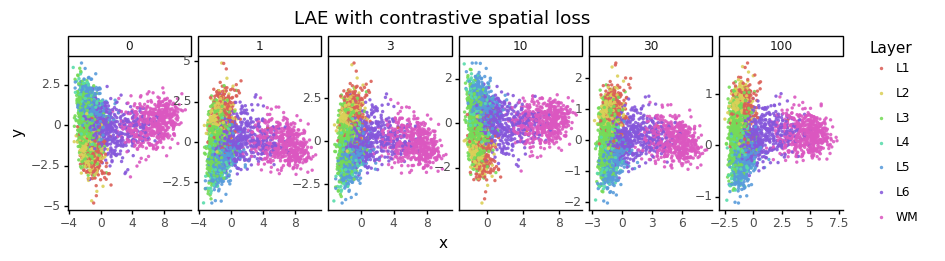

<ggplot: (326186429)>

In [15]:
h_list = [m.encode(y).detach() for m in lae_w_csp_list]

df_lae_h = []
for i, h in enumerate(h_list):
    _df = pd.DataFrame(h[:,0:3], columns=['x', 'y', 'z'])
    _df['l_sp_loss'] = l_sp_list[i]
    _df['layer'] = anno_true['layer'].values
    df_lae_h.append(_df)

df_lae_h = pd.concat(df_lae_h)

ggplot(df_lae_h, aes(x = 'x', y = 'y', color = 'layer')) + \
    facet_wrap('~ l_sp_loss', scales='free', nrow = 1) + \
    geom_point(size = 0.4, alpha = 0.8) + \
    theme_classic() + \
    labs(title = 'LAE with contrastive spatial loss', color = 'Layer') + \
    theme(figure_size = (10,2))